##### **Clustering K-means, Cure, DBSCAN**

Description: Clustering, Cure, DBSCAN clustering methods on a simple e-commerce dataset using kaggle data <br>

Dataset: https://www.kaggle.com/carrie1/ecommerce-data

In [1]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure
from mpl_toolkits import mplot3d
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load the dataset
df = pd.read_csv('./data/e-commerce_data(kaggle).csv',encoding="ISO-8859-1",
                 dtype={'CustomerID': str,'InvoiceID': str})
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format=("%m/%d/%Y %H:%M"))
df=df[df['Country']=='United Kingdom']

In [3]:
# cleaning and removing some outliers
df=df.dropna().reset_index()
df = df[df.Quantity <=100000]
df = df[df.Quantity >=0]
df=df.sort_values(['Quantity'],ascending=False)
df

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
361513,540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
34256,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
336266,502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256,United Kingdom
278780,421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom
131061,206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom
...,...,...,...,...,...,...,...,...,...
39778,72314,542239,47578A,ENGLISH ROSE SMALL SCENTED FLOWER,1,2011-01-26 14:35:00,0.85,17786,United Kingdom
39779,72315,542239,21407,BROWN CHECK CAT DOORSTOP,1,2011-01-26 14:35:00,4.25,17786,United Kingdom
39780,72316,542239,85040B,SET/4 BLUE FLOWER CANDLES IN BOWL,1,2011-01-26 14:35:00,1.65,17786,United Kingdom
105935,170117,551277,23135,SMALL ZINC HEART WALL ORGANISER,1,2011-04-27 13:06:00,5.75,13637,United Kingdom


<Axes: >

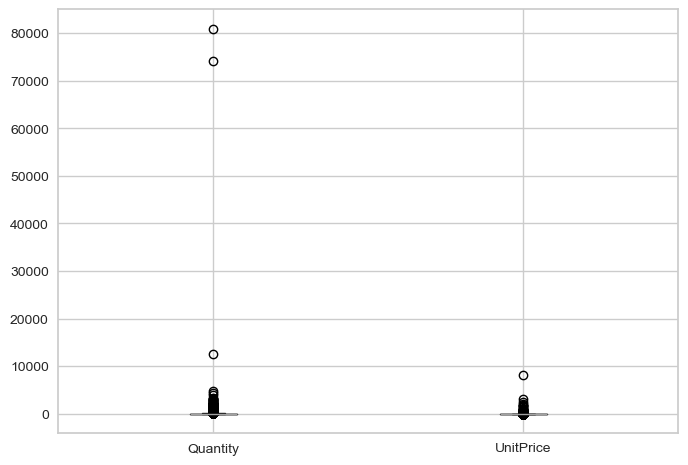

In [4]:
# is ont a very nice boxplot
plt.figure()
df.boxplot(column=['Quantity','UnitPrice'])

##### Creating metrics to perform a customer segmentation

How often a customer buys? this is the core metric

In [5]:
df = (df.groupby(['CustomerID','Country'],as_index=False)
          .agg({'InvoiceNo':'nunique', 'StockCode':'nunique','UnitPrice':'mean','Quantity':'sum'}))

df.reset_index()
df['avgitems']=df['Quantity']/df['InvoiceNo']
df1=df[['InvoiceNo','UnitPrice','avgitems']]
df1

,InvoiceNo,UnitPrice,avgitems
0,1,1.040000,74215.000000
1,11,4.367864,115.909091
2,210,2.655701,122.609524
3,5,4.999950,294.200000
4,4,1.904746,180.500000
...,...,...,...
3916,1,4.765000,45.000000
3917,1,5.622857,54.000000
3918,2,5.199167,51.500000
3919,16,1.614987,87.312500


##### Removing outliers

In [6]:
# removing outliers to have more stable clustering
i=0 
while i<=len(df1)-1:
    quartile_1, quartile_3 = np.percentile(df1['avgitems'], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr *1.5 )
    upper_bound = quartile_3 + (iqr *1.5)
    
    if df1.loc[i,'avgitems']> upper_bound:
        df1.loc[i,'outlier']=1
    elif df1.loc[i,'avgitems']< lower_bound:
        df1.loc[i,'outlier']=1
    else:
        df1.loc[i,'outlier']=0
    i=i+1
    
df1

,InvoiceNo,UnitPrice,avgitems,outlier
0,1,1.040000,74215.000000,1.0
1,11,4.367864,115.909091,0.0
2,210,2.655701,122.609524,0.0
3,5,4.999950,294.200000,0.0
4,4,1.904746,180.500000,0.0
...,...,...,...,...
3916,1,4.765000,45.000000,0.0
3917,1,5.622857,54.000000,0.0
3918,2,5.199167,51.500000,0.0
3919,16,1.614987,87.312500,0.0


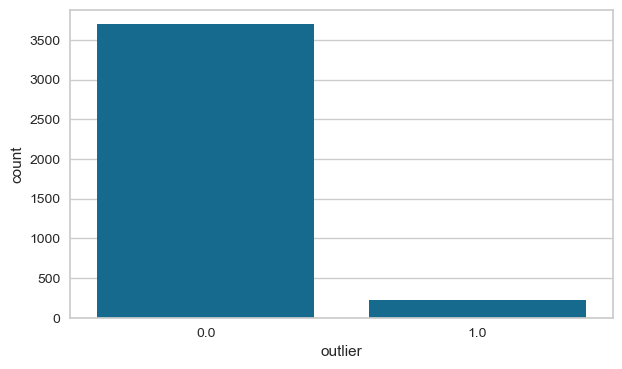

In [7]:
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.countplot(data=df1, x="outlier")
plt.show()

In [8]:
df1=df1[df1['outlier']==0]
df1= df1.drop(columns=['outlier'])
df1

,InvoiceNo,UnitPrice,avgitems
1,11,4.367864,115.909091
2,210,2.655701,122.609524
3,5,4.999950,294.200000
4,4,1.904746,180.500000
5,1,2.498333,70.000000
...,...,...,...
3915,1,3.283333,66.000000
3916,1,4.765000,45.000000
3917,1,5.622857,54.000000
3918,2,5.199167,51.500000


##### K-Means without data  normalization
##### Applying elbow method

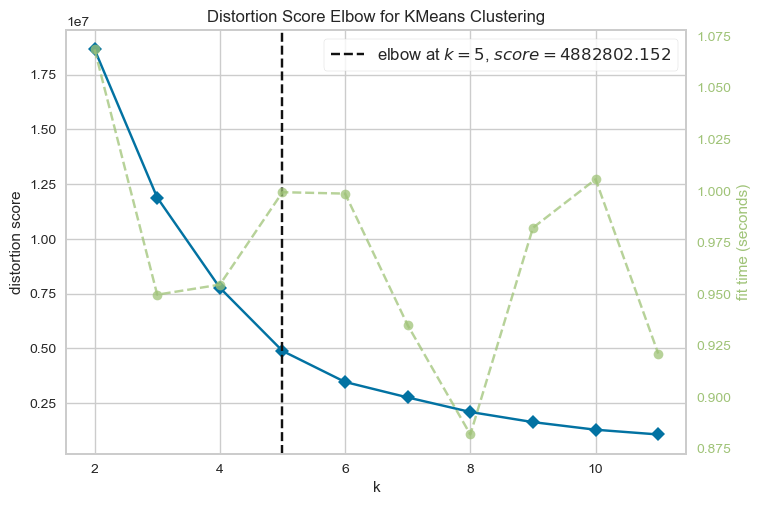

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(df1)  
visualizer.show()        

##### Kmeans

[[4.52815226e+00 3.05843712e+00 1.55129959e+02]
 [4.85461441e+00 2.68955277e+00 2.64729122e+02]
 [4.49019608e+00 2.69336694e+00 4.01317509e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]
 [3.24864025e+00 5.78516528e+00 6.61183084e+01]]
[0 0 1 ... 4 4 4]


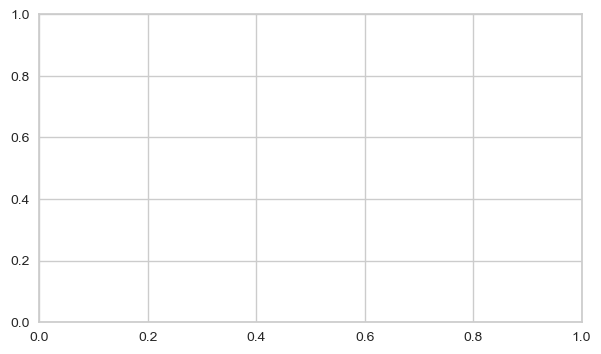

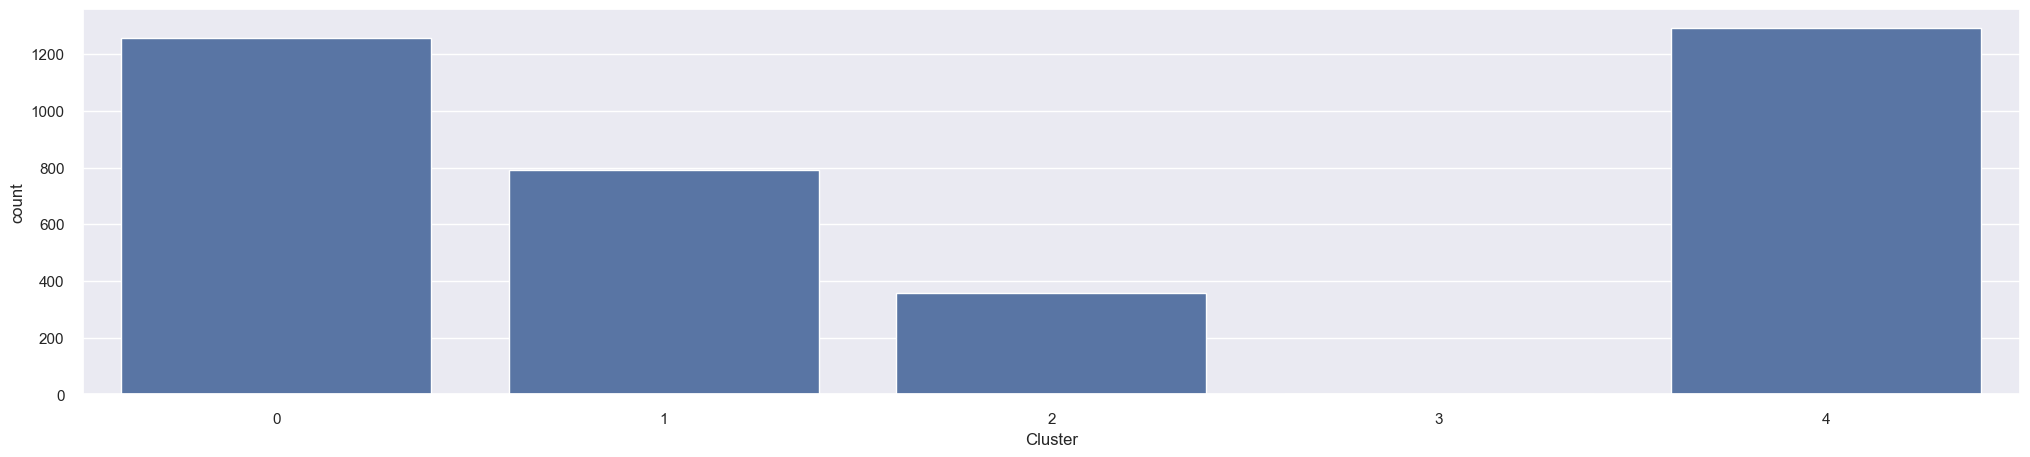

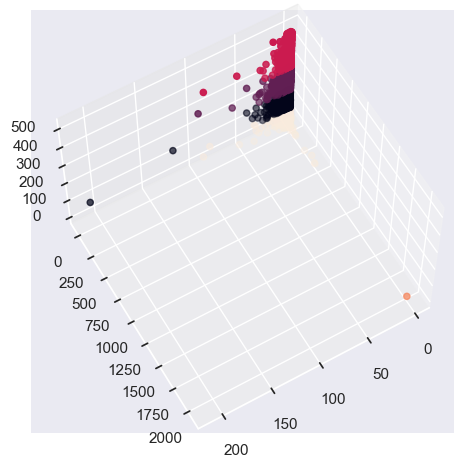

In [10]:
model = KMeans()
kmeans = KMeans(5)
kmeans.fit(df1)
identified_clusters = kmeans.fit_predict(df1)
data_with_clusters = df1.copy()
data_with_clusters['Cluster'] = identified_clusters
print(kmeans.cluster_centers_)
print(identified_clusters)

fig,ax = plt.subplots(figsize=(7,4))

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=data_with_clusters)
data_with_clusters.groupby(['Cluster']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)
plt.show()

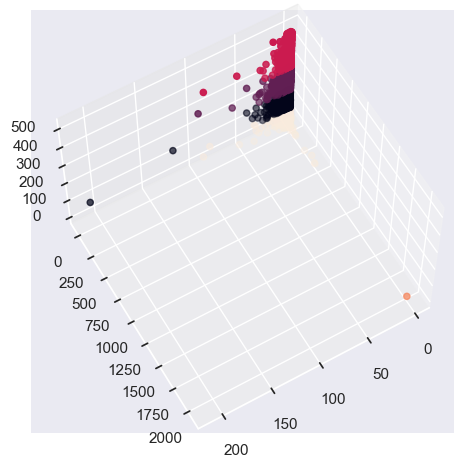

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

##### K-Means with  normalized data

##### (1) Scaling Data

In [12]:
scaler = StandardScaler()
x_scaled=scaler.fit(df1)
x_scaled = scaler.fit_transform(df1)
x_scaled

array([[ 9.85382036e-01, -2.05703306e-03, -5.06000494e-01],
       [ 2.96032772e+01, -4.91872672e-02, -4.44818118e-01],
       [ 1.22530926e-01,  1.53422084e-02,  1.12199302e+00],
       ...,
       [-4.52703148e-01,  3.24888021e-02, -1.07129908e+00],
       [-3.08894629e-01,  2.08259956e-02, -1.09412685e+00],
       [ 1.70442463e+00, -7.78346994e-02, -7.67119048e-01]])

##### Using Elbow method to find number of clusters

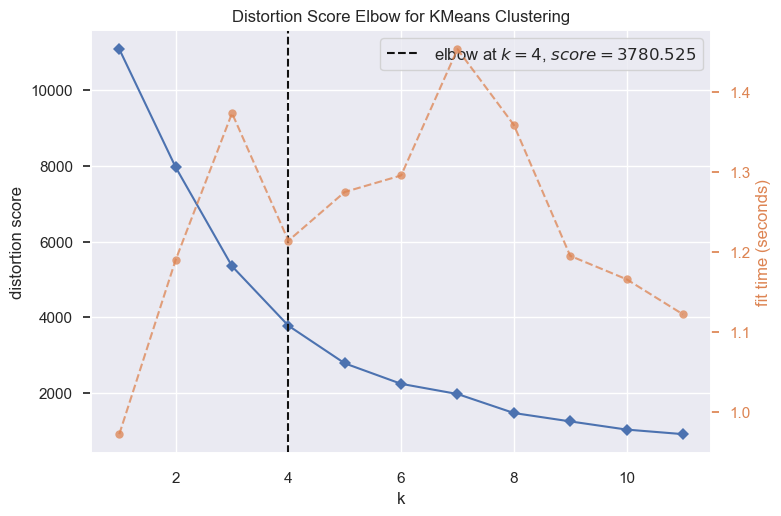

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)  
visualizer.show()     

##### Applying Kmeans

[0 0 1 ... 4 4 4]
[[4.52815226e+00 3.05843712e+00 1.55129959e+02]
 [4.85461441e+00 2.68955277e+00 2.64729122e+02]
 [4.49019608e+00 2.69336694e+00 4.01317509e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]
 [3.24864025e+00 5.78516528e+00 6.61183084e+01]]


,InvoiceNo,UnitPrice,avgitems
cluster_pred,,,
0,2480,2480,2480
1,1,1,1
2,9,9,9
3,1207,1207,1207


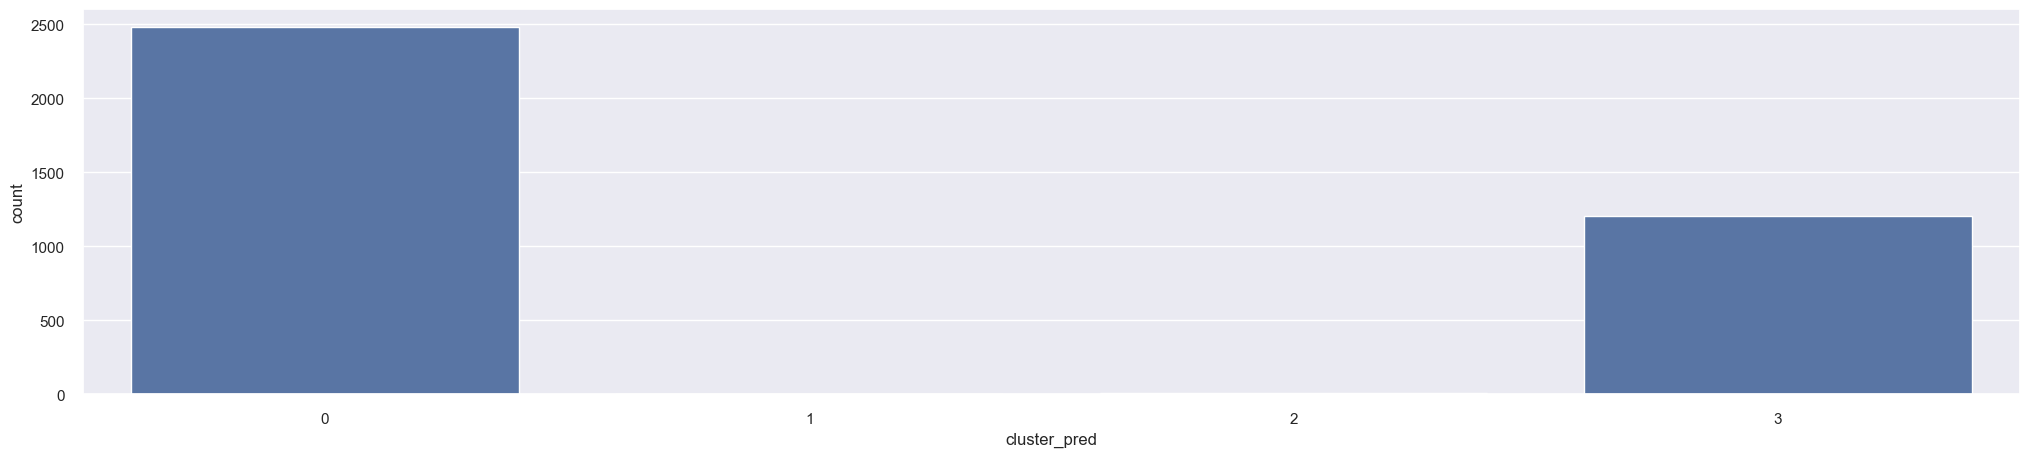

In [14]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
clusters_scaled = df1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(kmeans.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

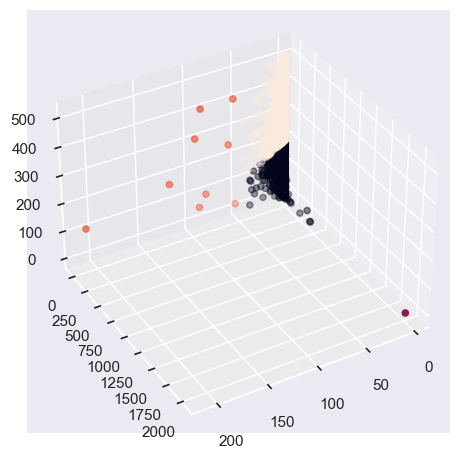

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['InvoiceNo']
yline=clusters_scaled['avgitems']
zline=clusters_scaled['UnitPrice']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(35, 60)

##### Cure Algorithm

clusters: [[4.163192581807036, 4.445210985690676, 177.2235242091012], [2.0, 1.9079374999999998, 6916.666666666666], [1.0, 0.0, 12540.0], [2.0, 1.6600000000000001, 40498.5], [1.0, 1.04, 74215.0]]
Sample:  ./pandas.txt 		Execution time:  44.7274207000155 

[26098, 2, 1, 1, 1]


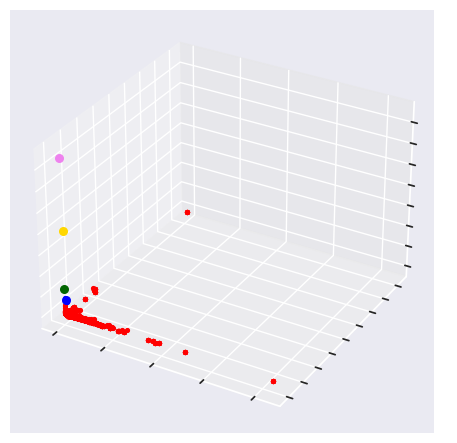

In [16]:
def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, 
                        ccore_flag=True):
    sample = read_sample(path)
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()
    return    
    
#rec = df1.to_records(index=False)

#df1.to_csv('./pandas.txt', header=None, index=None, sep=' ', mode='a')
#path= './pandas.txt'
#template_clustering(5,path)


##### Cure Algorithm with Normalized Data

clusters: [[-0.45054640025726306, -0.09500923823972617, 53.33486717069685], [-0.3117506400900154, -0.07776525668898801, 29.023687336447395], [0.00017132832757658345, -0.01491246573421244, -0.0051656603492065516], [-0.4521639608167142, 55.98730882563015, -1.2106638267379732]]
Sample:  ./pa2ndas.txt 		Execution time:  14.282691800006432 

[1, 1, 15006, 4]


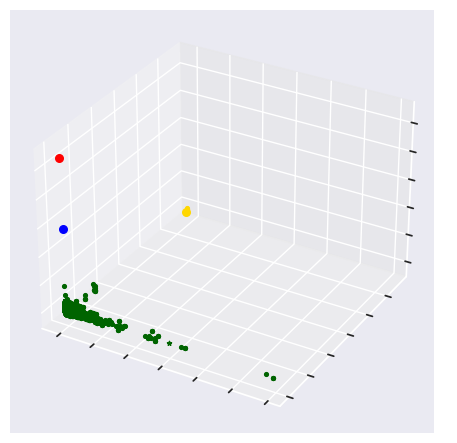

In [17]:
def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, ccore_flag=True):
    sample = read_sample(path)
    
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()
   


dtype = [('Col1','int32'), ('Col2','float32'), ('Col3','float32')]
index = ['Row'+str(i) for i in range(1, len(x_scaled)+1)]

x_sc1 = pd.DataFrame(x_scaled, index=index)

#rec = x_sc1.to_records(index=False)
#x_sc1.to_csv('./pa2ndas.txt', header=None, index=None, sep=' ', mode='a')

#path= './pa2ndas.txt'
#template_clustering(4,path)


##### DBSCAN on Normalized Data

,InvoiceNo,UnitPrice,avgitems
cluster_pred,,,
-1,44,44,44
0,3648,3648,3648
1,5,5,5


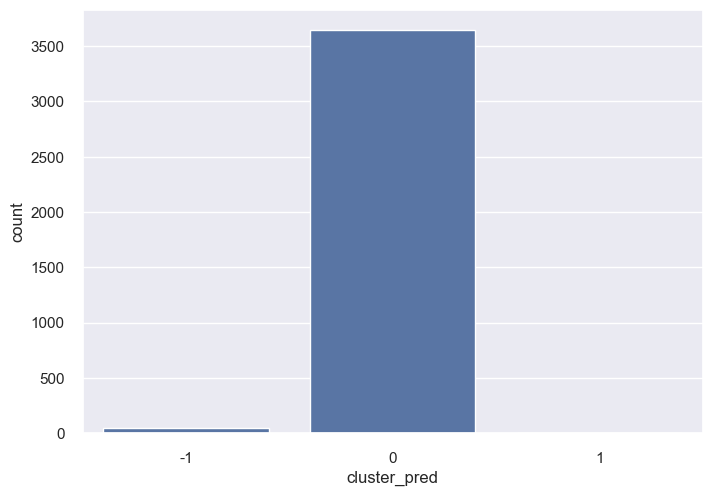

In [18]:
stscaler = StandardScaler().fit(df1)
db11 = stscaler.transform(df1)
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(db11)
clusters_scaled = df1.copy()
clusters_scaled['cluster_pred']=dbsc.fit_predict(db11)
clusters_scaled
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()


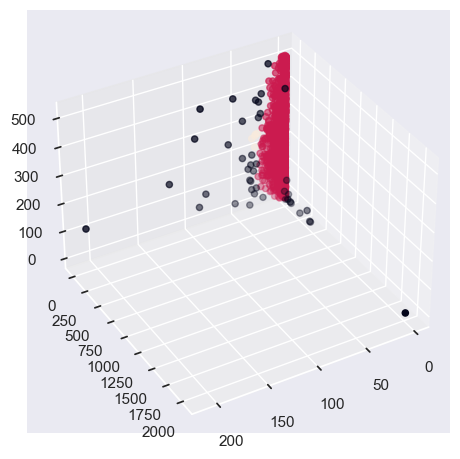

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['InvoiceNo']
yline=clusters_scaled['avgitems']
zline=clusters_scaled['UnitPrice']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(35, 60)

##### More DBSCAN 

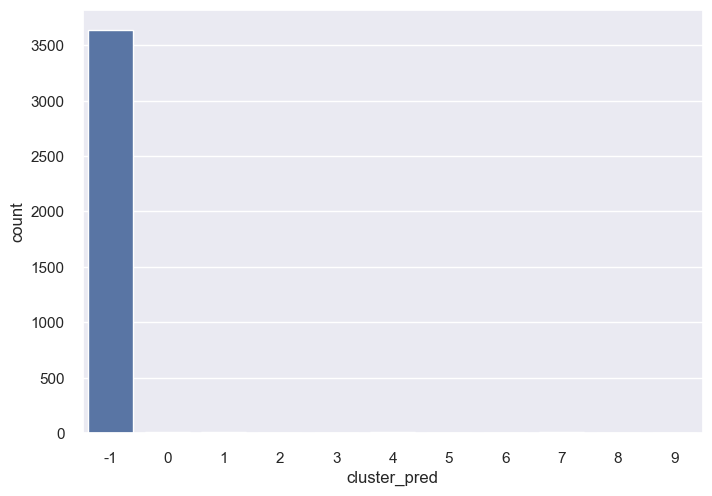

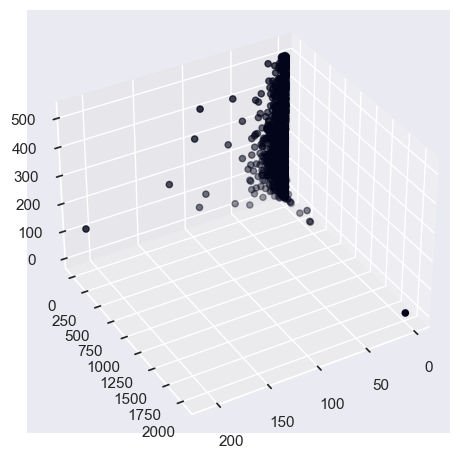

In [20]:
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(df1)
data_with_clusters = df1.copy()
data_with_clusters['cluster_pred']=dbsc.fit_predict(data_with_clusters)
data_with_clusters
ax = sns.countplot(x="cluster_pred", data=data_with_clusters)
data_with_clusters.groupby(['cluster_pred']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['cluster_pred'])
ax.view_init(35, 60)

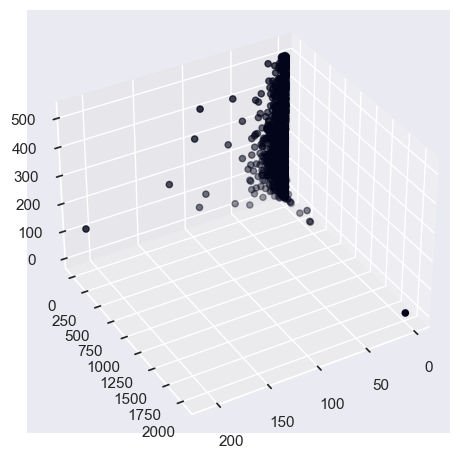

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['cluster_pred'])
ax.view_init(35, 60)

In [22]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.8.0
mpl_toolkits        NA
numpy               1.26.4
pandas              2.1.4
pyclustering        0.10.1.2
seaborn             0.13.2
session_info        1.0.0
sklearn             1.2.2
yellowbrick         1.5
-----
IPython             8.20.0
jupyter_client      8.6.0
jupyter_core        5.5.0
jupyterlab          4.0.11
notebook            7.0.8
-----
Python 3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-03-24 10:48
